In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import torch
mpl.rcParams['figure.figsize'] = (20,11)
sns.set_context('poster')
import re
from Models.generator import GeneratorWithResiduals
from torch.utils.data import DataLoader
from Utils.dataloader import TILDataset
from torchvision import transforms
import torchvision.utils as vutils
from scipy.linalg import sqrtm
from skimage.transform import resize
from torch.utils.data import Subset
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def extract_log_values(log_str):
    pattern = r'Epoch \[(\d+)/(\d+)\], Step \[(\d+)/(\d+)\], Loss D: ([\d.]+), Loss G: ([\d.]+), D\(x\): ([\d.]+), D\(G\(z\)\): ([\d.]+)/([\d.]+)'
    match = re.match(pattern, log_str)

    if match:
        epoch = int(match.group(1))
        total_epochs = int(match.group(2))
        step = int(match.group(3))
        total_steps = int(match.group(4))
        loss_d = float(match.group(5))
        loss_g = float(match.group(6))
        d_x = float(match.group(7))
        d_g_z_pre = float(match.group(8))
        d_g_z_post = float(match.group(9))

        return {
            'epoch': epoch,
            'total_epochs': total_epochs,
            'step': step,
            'total_steps': total_steps,
            'loss_d': loss_d,
            'loss_g': loss_g,
            'd_x': d_x,
            'd_g_z_pre': d_g_z_pre,
            'd_g_z_post': d_g_z_post
        }
    else:
        print("No match found")
        return None

In [15]:
loss_log = torch.load('loss_log.pth')

In [22]:
loss_log_df = pd.DataFrame([extract_log_values(i) for i in loss_log])
loss_log_df = loss_log_df.groupby('epoch').mean()
loss_log_df

,total_epochs,step,total_steps,loss_d,loss_g,d_x,d_g_z_pre,d_g_z_post
epoch,,,,,,,,
1,500.0,439.0,879.0,1.416698,1.135970,0.636312,0.474019,0.391220
2,500.0,439.0,879.0,1.363173,1.102934,0.625907,0.477950,0.388094
3,500.0,439.0,879.0,1.354446,1.178711,0.621893,0.477343,0.361136
4,500.0,439.0,879.0,1.320513,1.199923,0.623642,0.473218,0.346558
5,500.0,439.0,879.0,1.308748,1.153357,0.619776,0.478238,0.353847
...,...,...,...,...,...,...,...,...
103,500.0,439.0,879.0,0.739346,2.031029,0.899712,0.199931,0.145220
104,500.0,439.0,879.0,0.728324,2.023927,0.903440,0.196105,0.144740
105,500.0,439.0,879.0,0.736806,2.050536,0.902806,0.197443,0.141961


In [34]:
nz = 100  
ngf = 64  
nc = 3  
n_classes = 9

generator = GeneratorWithResiduals(nz, ngf, nc, n_classes)


In [35]:
checkpoint = torch.load("E:/TILcGAN/checkpoints/ckpt_epoch_107.pth")
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()


GeneratorWithResiduals(
  (label_emb): Embedding(9, 9)
  (l1): Sequential(
    (0): Linear(in_features=109, out_features=16384, bias=True)
  )
  (first_layer): Sequential(
    (0): BatchNorm2d(109, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(109, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (conv_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Bat

In [54]:
generator.to(device)

GeneratorWithResiduals(
  (label_emb): Embedding(9, 9)
  (l1): Sequential(
    (0): Linear(in_features=109, out_features=16384, bias=True)
  )
  (first_layer): Sequential(
    (0): BatchNorm2d(109, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(109, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (conv_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Bat

In [43]:
root_dir = 'E:/TILcGAN/Data/train/'
batch_size = 64
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = TILDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# 1. Loss Curves 

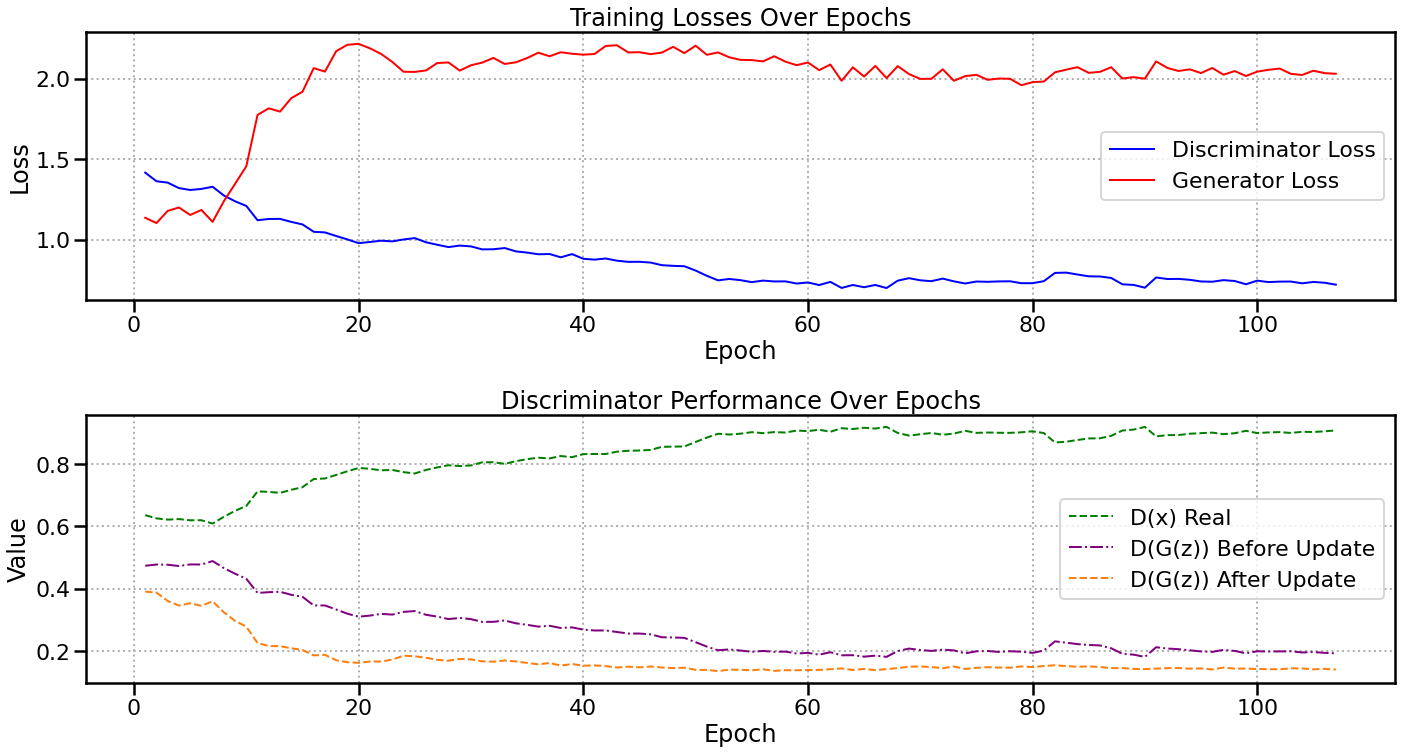

In [31]:
plt.subplot(2, 1, 1)
plt.plot(loss_log_df.index, loss_log_df['loss_d'], label='Discriminator Loss', color='blue', linewidth=2)
plt.plot(loss_log_df.index, loss_log_df['loss_g'], label='Generator Loss', color='red', linewidth=2)
plt.title('Training Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(lw=2,ls=':')

plt.subplot(2, 1, 2)
plt.plot(loss_log_df.index, loss_log_df['d_x'], label='D(x) Real', color='green', linewidth=2, linestyle='--')
plt.plot(loss_log_df.index, loss_log_df['d_g_z_pre'], label='D(G(z)) Before Update', c='purple', linewidth=2, linestyle='-.')
plt.plot(loss_log_df.index, loss_log_df['d_g_z_post'], label='D(G(z)) After Update', c='tab:orange', linewidth=2, linestyle='--')
plt.title('Discriminator Performance Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(lw=2,ls=':')

plt.tight_layout()
plt.savefig('plots/train_loss_curves.png',dpi=150,facecolor='white',bbox_inches='tight')
plt.show()

In [11]:
loss_log[0]

'Epoch [1/500], Step [0/879], Loss D: 1.4846761226654053, Loss G: 1.3344980478286743, D(x): 0.4598681926727295, D(G(z)): 0.4803699254989624/0.6185480356216431'

# 2. Comparing Generated Images to Real Ones

C:\Users\Tomas\AppData\Local\Temp\ipykernel_20156\1743814952.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "face_color" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('plots/REAL_samples.png',face_color='white')
C:\Users\Tomas\AppData\Local\Temp\ipykernel_20156\1743814952.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "face_color" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('plots/GENERATED_samples.png',face_color='white')


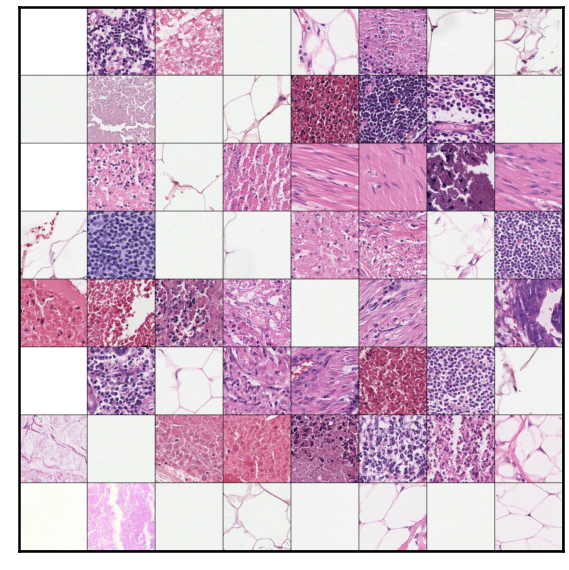

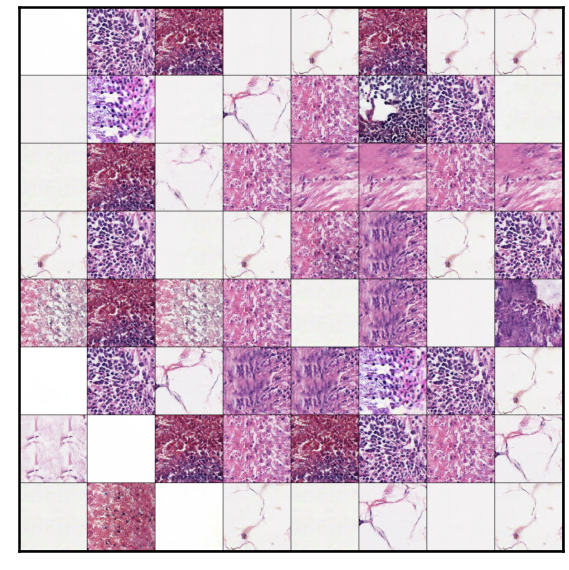

In [60]:
real_images, labels = next(iter(dataloader))
real_images, labels = real_images.to(device)[:64], labels.to(device)[:64]
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    fake_images = generator(fixed_noise, labels[:fixed_noise.size(0)]).detach().cpu()

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(np.transpose(vutils.make_grid(real_images.cpu(), padding=2, normalize=True), (1, 2, 0)))
plt.savefig('plots/REAL_samples.png',face_color='white')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.savefig('plots/GENERATED_samples.png',face_color='white')


# 3. Model Weights Visualization

In [100]:
activation_maps = []

def get_activation(name):
    def hook(model, input, output):
        activation_maps.append(output.detach())
    return hook

def visualize_activation_maps(activation_maps, num_columns=2, num_rows=2):
    max_filters = num_columns * num_rows  # Maximum of 36 filters to be displayed
    num_filters = activation_maps.shape[0]

    # If there are more filters than the max, randomly select 36
    if num_filters > max_filters:
        selected_indices = np.random.choice(num_filters, max_filters, replace=False)
        activation_maps = activation_maps[selected_indices]
    else:
        max_filters = num_filters  # Adjust max_filters to the actual number if less than 36
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < max_filters:
            # Normalize the activation map for better visualization
            activation_map = activation_maps[i].detach().cpu()
            activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
            ax.imshow(activation_map, cmap='jet')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [101]:
generator.conv_blocks[1].register_forward_hook(get_activation('conv1'))
generator.conv_blocks[-5].register_forward_hook(get_activation('conv5'))


In [102]:
latent_vector = torch.randn(1, nz, 1, 1, device=device)
labels = torch.randint(0, n_classes, (1,), device=device)

with torch.no_grad():
    generator.eval()
    _ = generator(latent_vector, labels)


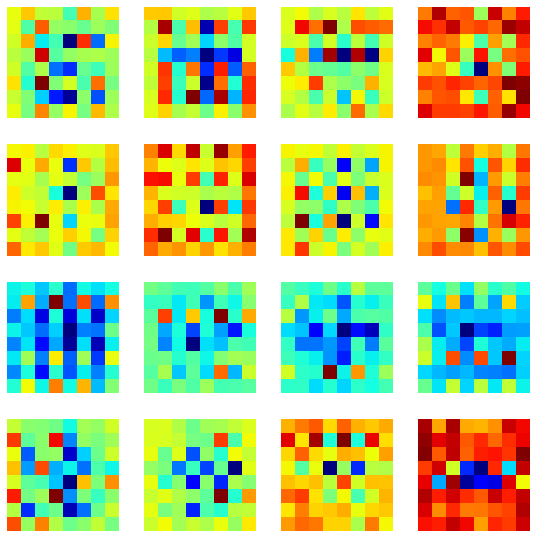

<Figure size 1440x792 with 0 Axes>

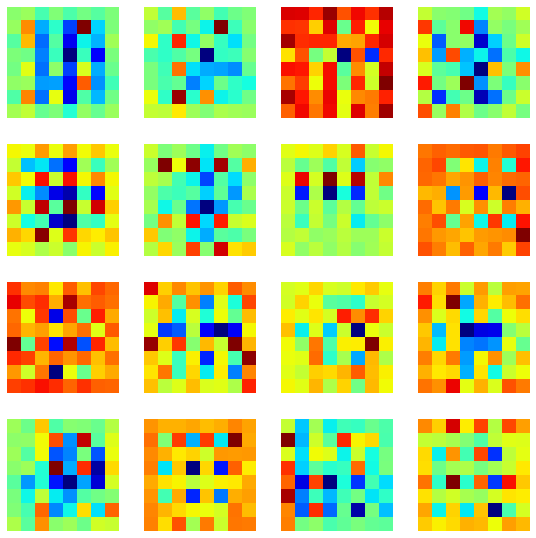

<Figure size 1440x792 with 0 Axes>

In [113]:
for layer_activations in activation_maps[:2]:
    visualize_activation_maps(layer_activations[0],num_columns=4,num_rows=4)
    plt.savefig('plots/conv1_filter.png')

In [122]:
generator.first_layer

Sequential(
  (0): BatchNorm2d(109, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU(inplace=True)
  (2): ConvTranspose2d(109, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [124]:
intermediate_outputs_r = []

def hook_fn(module, input, output):
    intermediate_outputs_r .append(output)


In [125]:
generator.first_layer[1].register_forward_hook(hook_fn)


In [168]:
N = 512
latent_vector = torch.randn(N, nz, 1, 1, device=device) 
label = torch.randint(0, n_classes, (N,), device=device)  

with torch.no_grad():
    generator.eval()  
    _ = generator(latent_vector, label)

    



In [169]:
first_layer_output = intermediate_outputs_r[0]

In [170]:
intermediate_outputs_r[3].shape

torch.Size([512, 109, 1, 1])

In [171]:
L_samples = intermediate_outputs_r[3].squeeze().cpu().numpy() 

In [172]:
from umap import UMAP

In [173]:
deccer = UMAP(2)
dec = deccer.fit_transform(L_samples)

In [174]:
dec_df = pd.DataFrame(dec,columns=['d1','d2'])

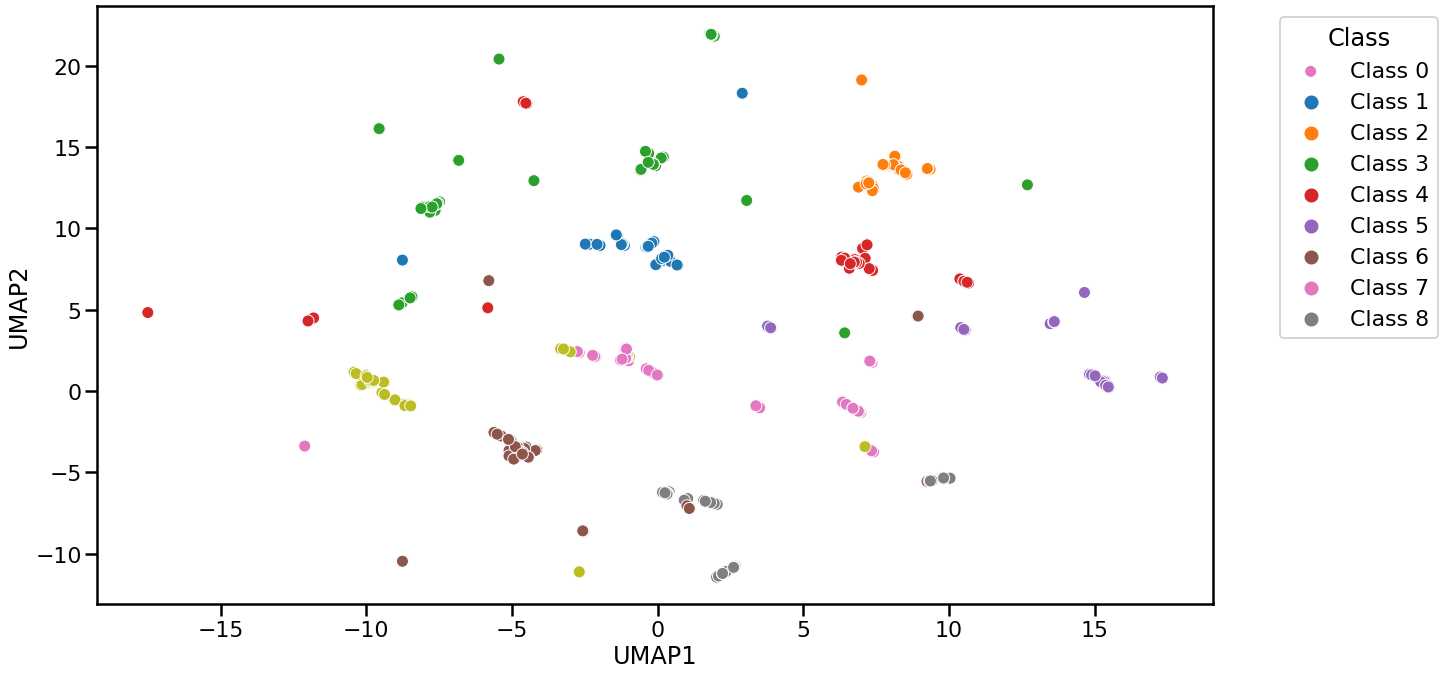

In [183]:
sns.scatterplot(dec_df,x='d1',y='d2',hue=label.cpu().numpy(),palette='tab10', legend='full')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Class', labels=[f'Class {i}' for i in range(n_classes)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('plots/generator_latent_by_class.png',facecolor='white',dpi=150,bbox_inches='tight')